# Historical simulations: slope and R^2 for all months
  
Katie Brennan  
December 2020

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os, sys
import warnings
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
# This is the package from Peter Huybers for doing coherence analysis 
# downloaded from: https://github.com/guidov/cmtm

#import cmtm 

In [3]:
import preprocess_utils as pputils
import analysis_utils as autils

In [7]:
def global_plot(fig,ax,var,lat,lon,title,bound):
    var_new, lon1 = add_cyclic_point(var, coord=lon)
    new_lon, new_lat = np.meshgrid(lon1, lat)

    cs = ax.pcolormesh(new_lon, new_lat, var_new,
                       vmin=-bound,vmax=bound,cmap='RdBu_r',
                       transform=ccrs.PlateCarree())
#    plt.colorbar(cs, ax=ax)
    ax.coastlines(resolution='110m', linewidth=0.5)
    ax.set_title(title, fontsize=16)
    
    return cs

In [4]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

### Process CMIP6 models: 

In [10]:
path = '/glade/scratch/mkbren/cmip6_si_tas/cmip6_preprocessed/historical/'

preprocessed_files = os.listdir(path)
preprocessed_models = [d.split('_')[0] for d in preprocessed_files]
preprocessed_models = list(set(preprocessed_models))
preprocessed_models.remove('ACCESS-CM2')
preprocessed_models.remove('AWI-ESM-1-1-LR')
preprocessed_models.remove('KIOST-ESM')
preprocessed_models.remove('NESM3')
preprocessed_models.remove('ACCESS-ESM1-5') #file didn't seem to be written correctly -> need to re-preprocess
len(preprocessed_models)

21

In [11]:
preprocessed_models

['CESM2',
 'MPI-ESM1-2-HR',
 'NorCPM1',
 'NorESM2-MM',
 'E3SM-1-0',
 'MIROC6',
 'CMCC-CM2-SR5',
 'CIESM',
 'EC-Earth3',
 'MPI-ESM-1-2-HAM',
 'CESM2-WACCM-FV2',
 'EC-Earth3-AerChem',
 'CESM2-FV2',
 'E3SM-1-1',
 'EC-Earth3-Veg-LR',
 'MRI-ESM2-0',
 'E3SM-1-1-ECA',
 'EC-Earth3-Veg',
 'CESM2-WACCM',
 'NorESM2-LM',
 'MPI-ESM1-2-LR']

In [12]:
all_months = [1,2,3,4,5,6,7,8,9,10,11,12]
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

# Regress total SIE and Arctic mean temperature: 

In [13]:
corr_all = {}
lat_all = {}
lon_all = {}

for mod in preprocessed_models: 
    print('Working on '+mod+"...")
    filename = mod+'_historical_siconc_sithick_tas_pan_arctic_fields.nc'
    data = xr.load_dataset(os.path.join(path,filename))

    filename_tas = mod+'_historical_tas_full_fields.nc'
    data_tas = xr.load_dataset(os.path.join(path,filename_tas))
    
    corr = np.zeros((data_tas.latitude.shape[0],data_tas.longitude.shape[0]))

    for i in range(data_tas.latitude.shape[0]):
        for j in range(data_tas.longitude.shape[0]):
            corr[i,j] = np.corrcoef(data.sie_tot_arc_anom,data_tas.tas[:,i,j])[0,1]
            
    corr_all[mod] = corr
    lat_all[mod] = data_tas.latitude
    lon_all[mod] = data_tas.longitude

Working on CESM2...
Working on MPI-ESM1-2-HR...
Working on NorCPM1...
Working on NorESM2-MM...
Working on E3SM-1-0...
Working on MIROC6...
Working on CMCC-CM2-SR5...
Working on CIESM...
Working on EC-Earth3...
Working on MPI-ESM-1-2-HAM...
Working on CESM2-WACCM-FV2...
Working on EC-Earth3-AerChem...
Working on CESM2-FV2...
Working on E3SM-1-1...
Working on EC-Earth3-Veg-LR...
Working on MRI-ESM2-0...
Working on E3SM-1-1-ECA...
Working on EC-Earth3-Veg...
Working on CESM2-WACCM...
Working on NorESM2-LM...
Working on MPI-ESM1-2-LR...


In [14]:
# mod = 'MIROC6'

# filename = mod+'_historical_siconc_sithick_tas_pan_arctic_fields.nc'
# data = xr.load_dataset(os.path.join(path,filename))

# filename_tas = mod+'_historical_tas_full_fields.nc'
# data_tas = xr.load_dataset(os.path.join(path,filename_tas))

# corr = np.zeros((data_tas.latitude.shape[0],data_tas.longitude.shape[0]))

# for i in range(data_tas.latitude.shape[0]):
#     for j in range(data_tas.longitude.shape[0]):
#         corr[i,j] = np.corrcoef(data.sie_tot_arc_anom,data_tas.tas[:,i,j])[0,1]

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


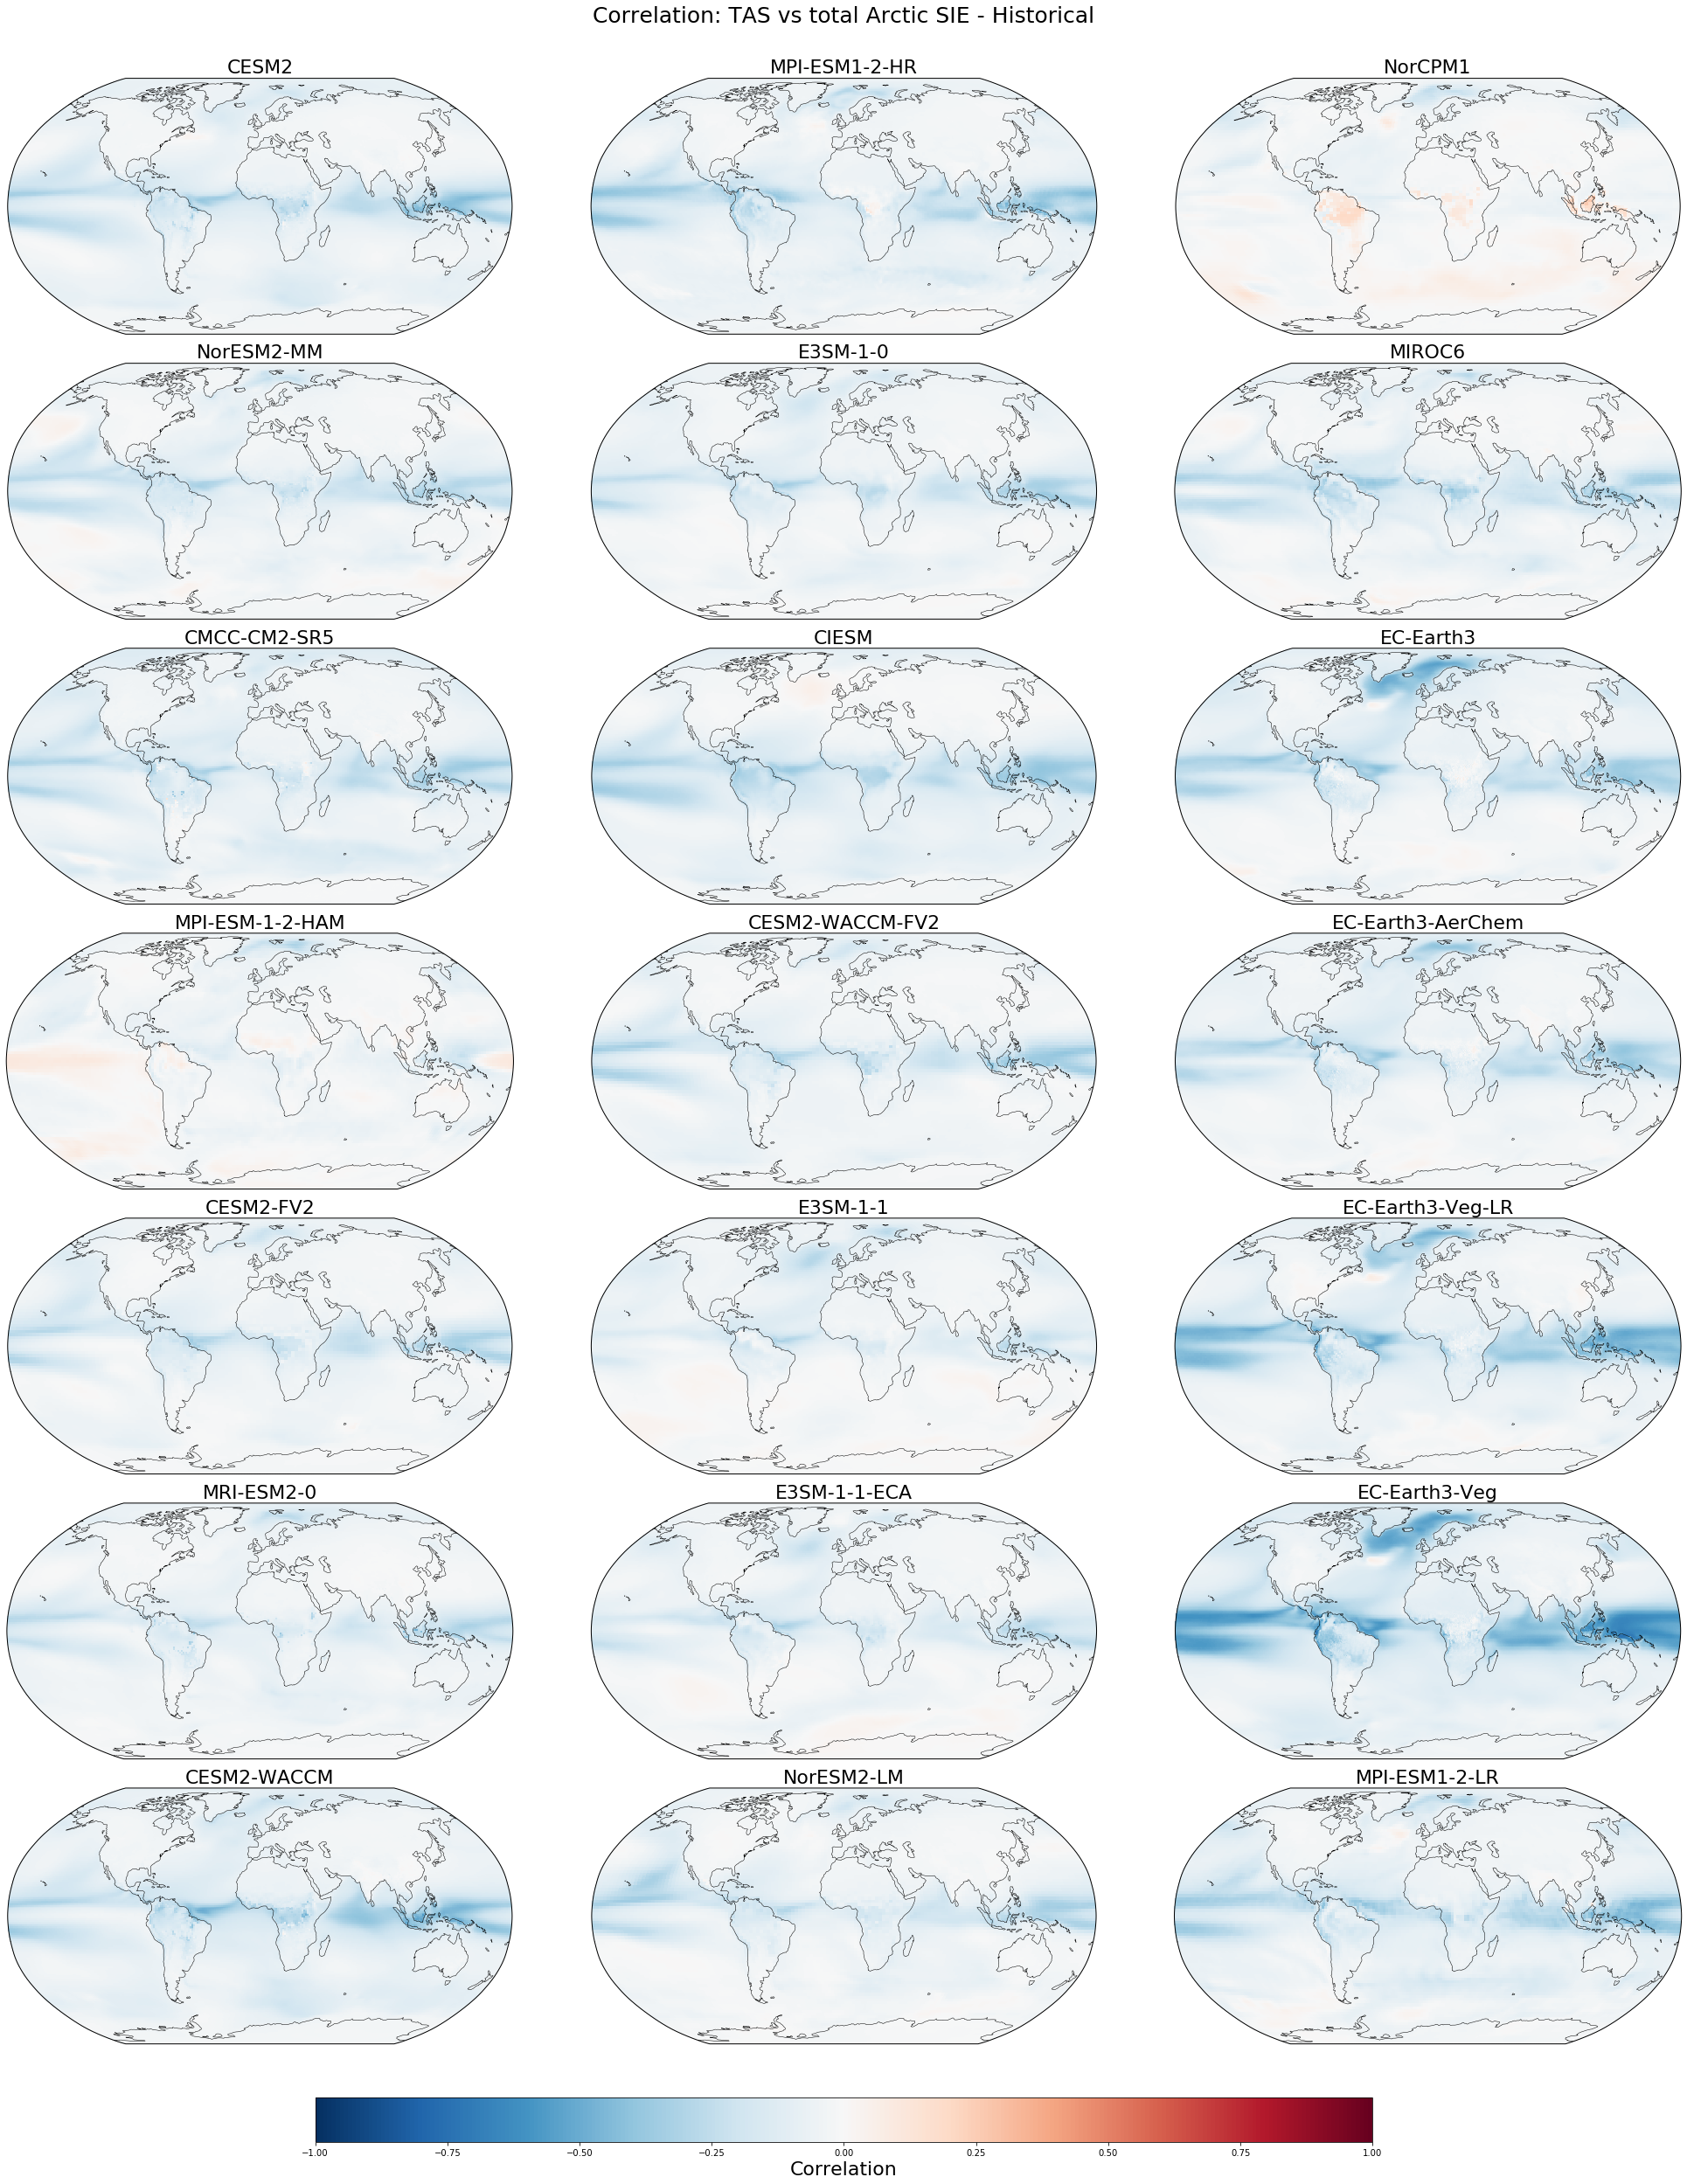

In [22]:
nmods = len(corr_all.keys())
ncols = np.ceil(nmods/3)

fig,ax = plt.subplots(int(ncols),3, figsize=(int(4*ncols),35), subplot_kw = proj)
ax=ax.flatten()

for i,mod in enumerate(corr_all.keys()):
    cs = autils.global_plot(fig,ax[i],corr_all[mod],lat_all[mod],lon_all[mod],mod,1.0)
    ax[i].set_title(mod,fontsize=22)
    
axc = fig.add_axes([0.2,0.01,0.6,0.02])
cb = fig.colorbar(cs, cax=axc,orientation='horizontal')
cb.set_label('Correlation',fontsize=22)

fig.suptitle('Correlation: TAS vs total Arctic SIE - Historical', fontsize=25)
plt.tight_layout(rect=(0,0.05,1,0.96))

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


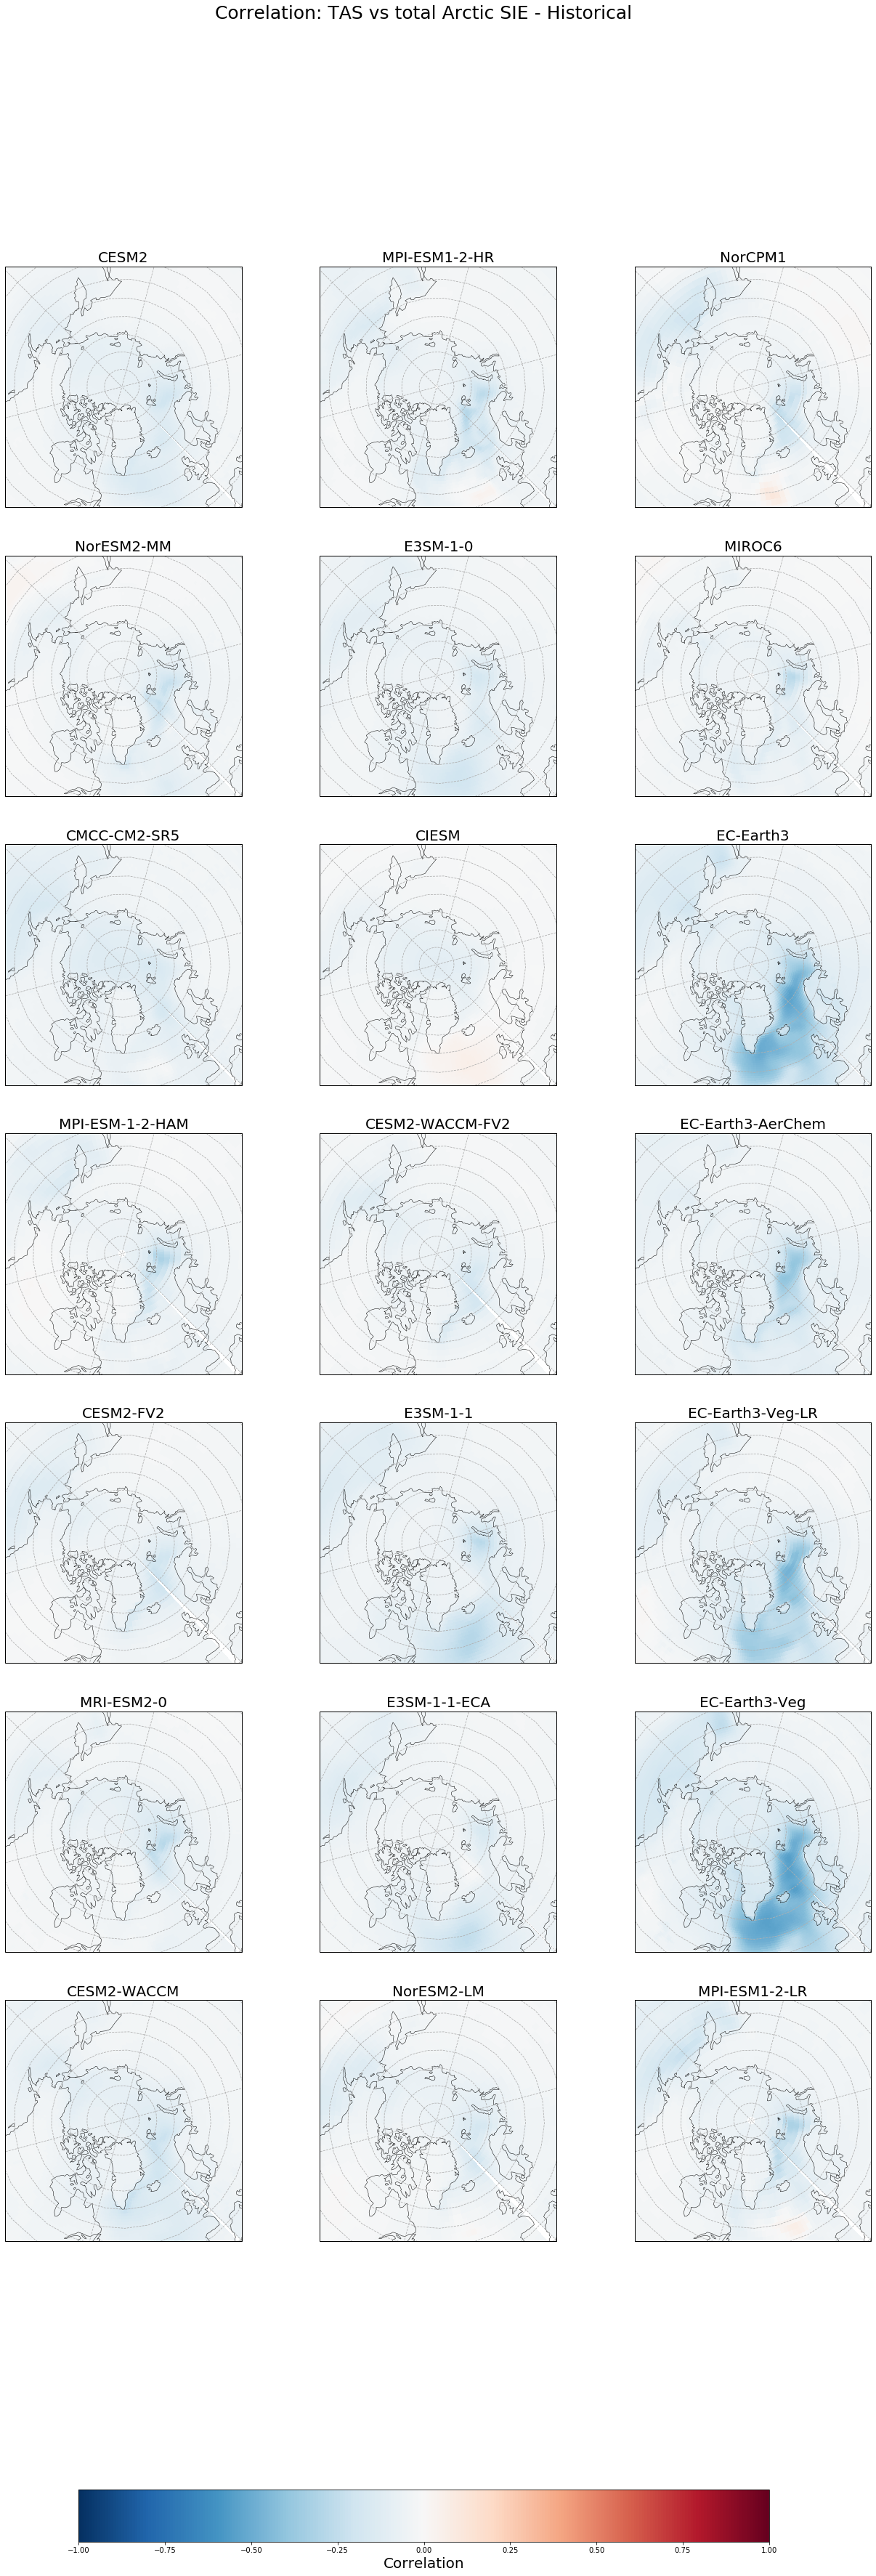

In [31]:
nmods = len(corr_all.keys())
ncols = np.ceil(nmods/3)

fig,ax = plt.subplots(int(ncols),3, figsize=(22,50), subplot_kw = arc_proj)
ax=ax.flatten()

for i,mod in enumerate(corr_all.keys()):
    if i is len(corr_all.keys()):
        cb = True
    else: 
        cb = False 
    autils.sub_arctic_plot(ax[i],fig,corr_all[mod],lat_all[mod],lon_all[mod],maxv=1,minv=-1, colorbar=cb)
    ax[i].set_title(mod, fontsize=20)
    
axc = fig.add_axes([0.2,0.01,0.6,0.02])
cb = fig.colorbar(cs, cax=axc,orientation='horizontal')
cb.set_label('Correlation',fontsize=20)

fig.suptitle('Correlation: TAS vs total Arctic SIE - Historical', fontsize=25)
plt.tight_layout(rect=(0,0.05,1,0.96))

Text(0.5, 1.0, 'MIROC6')

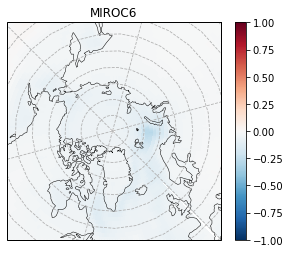

In [43]:
fig,ax = plt.subplots(1,1, figsize=(5,4), subplot_kw = arc_proj)
#ax=ax.flatten()

autils.sub_arctic_plot(ax,fig,corr,data_tas.latitude,data_tas.longitude,maxv=1,minv=-1)

ax.set_title(mod)

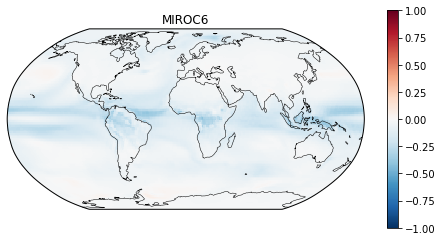

In [38]:
fig,ax = plt.subplots(1,1, figsize=(8,4), subplot_kw = proj)
#ax=ax.flatten()

cs = autils.global_plot(fig,ax,corr,data_tas.latitude,data_tas.longitude,mod,1.0)

#plt.colorbar(cs,ax=ax)
ax.set_title(mod)